In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from torchvision.transforms import Resize, ToTensor, Normalize

# GPU 사용양 확인할 수 있는 util
from GPUtil import showUtilization as gpu_usage

gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 19% |


In [19]:
train_dir = '/opt/ml/input/data/train/'
test_dir = '/opt/ml/input/data/eval/'
labels = pd.read_csv('/opt/ml/correct_label.csv')
labels.head()

Unnamed: 0                                               file  gender  \
0           0  /opt/ml/input/data/train/images/000001_female_...       1   
1           1  /opt/ml/input/data/train/images/000001_female_...       1   
2           2  /opt/ml/input/data/train/images/000001_female_...       1   
3           3  /opt/ml/input/data/train/images/000001_female_...       1   
4           4  /opt/ml/input/data/train/images/000001_female_...       1   

   mask  age      id  class  
0     0    1  000001      4  
1     1    1  000001     10  
2     0    1  000001      4  
3     0    1  000001      4  
4     2    1  000001     16

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(device))

Tesla V100-PCIE-32GB


train.csv를 학습에 맞는 형태로 바꿔주기

In [6]:
import glob
images = []
for path in labels['path']:
    img_folder = glob.glob(os.path.join(train_dir, 'images', path, '*'))
    for img in img_folder:
        img_dict = {}
        img_dict['file'] = img
        img_dict['gender'] = labels.loc[labels['path']==path, 'gender'].values[0]
        img_dict['age'] = labels.loc[labels['path']==path, 'age'].values[0]
        img_dict['mask'] = img.split('/')[-1].split('.')[0]
        images.append(img_dict)

In [7]:
full_labels = pd.DataFrame(images)
full_labels.sample(10)

file  gender  age  \
17121  /opt/ml/input/data/train/images/006415_female_...  female   18   
704    /opt/ml/input/data/train/images/000274_female_...  female   54   
11253  /opt/ml/input/data/train/images/003769_female_...  female   60   
9453   /opt/ml/input/data/train/images/003377_female_...  female   20   
16696  /opt/ml/input/data/train/images/006343_female_...  female   18   
5197   /opt/ml/input/data/train/images/001479_female_...  female   57   
343    /opt/ml/input/data/train/images/000077_male_As...    male   59   
8496   /opt/ml/input/data/train/images/003176_female_...  female   19   
12684  /opt/ml/input/data/train/images/004276_female_...  female   60   
18108  /opt/ml/input/data/train/images/006628_female_...  female   19   

                 mask  
17121           mask4  
704            normal  
11253          normal  
9453            mask1  
16696  incorrect_mask  
5197            mask1  
343             mask2  
8496            mask3  
12684           mask2  
18108           mask4

In [8]:
def gender_map(x):
    if x == 'male':
        return 0
    return 1

# def age_map(x):
#     return x[0]

def mask_map(x):
    if x == 'normal':
        return 2
    elif x == 'incorrect_mask':
        return 1
    else:
        return 0

full_labels['gender'] = full_labels['gender'].apply(gender_map)
# full_labels['age'] = full_labels['age'].apply(age_map)
full_labels['mask'] = full_labels['mask'].apply(mask_map)
full_labels.sample(10)

file  gender  age  mask
6008   /opt/ml/input/data/train/images/001604_male_As...       0   24     0
2650   /opt/ml/input/data/train/images/000901_female_...       1   49     2
17790  /opt/ml/input/data/train/images/006543_female_...       1   21     0
13444  /opt/ml/input/data/train/images/004444_male_As...       0   25     2
13045  /opt/ml/input/data/train/images/004354_male_As...       0   60     2
16377  /opt/ml/input/data/train/images/006211_male_As...       0   19     1
666    /opt/ml/input/data/train/images/000268_male_As...       0   59     1
8398   /opt/ml/input/data/train/images/003160_female_...       1   19     0
13491  /opt/ml/input/data/train/images/004454_male_As...       0   32     0
16598  /opt/ml/input/data/train/images/006258_female_...       1   20     1

In [9]:
len(full_labels)

18900

gender, mask, age를 그룹화해서 데이터 분포 확인

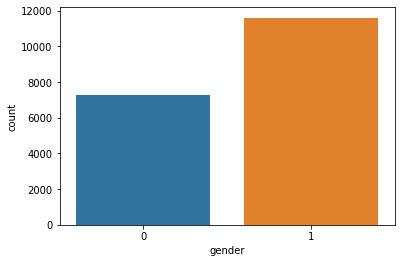

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.countplot(x='gender', data=full_labels)

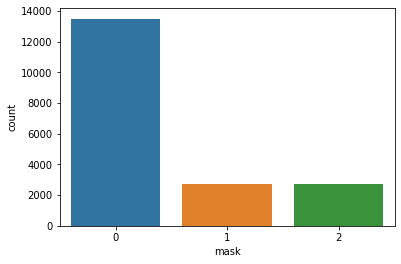

In [11]:
sns.countplot(x='mask', data=full_labels)

In [12]:
# sns.scatterplot(data=full_labels['age'])

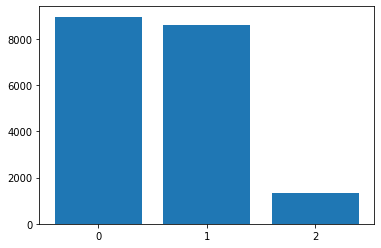

In [13]:
def age_section(x):
    if x < 30:
        return 0
    elif x < 60:
        return 1
    else:
        return 2
    
full_labels['map_age'] = full_labels['age'].apply(age_section)
plt.bar(range(3), full_labels['map_age'].value_counts())
plt.xticks(np.arange(0, 3, 1))
plt.show()

클래스를 18개로 보면 클래스별로 데이터 개수가 어떻게 될까?

In [14]:
full_labels['class'] = full_labels['gender']*3 + full_labels['map_age'] + full_labels['mask']*6
full_labels['class'].value_counts().sort_index()

0     2745
1     2050
2      415
3     3660
4     4085
5      545
6      549
7      410
8       83
9      732
10     817
11     109
12     549
13     410
14      83
15     732
16     817
17     109
Name: class, dtype: int64

In [15]:
# full_labels.csv 생성
init_dir = '/opt/ml/'
full_labels.to_csv(os.path.join(init_dir, 'full_labels.csv'), index=False)

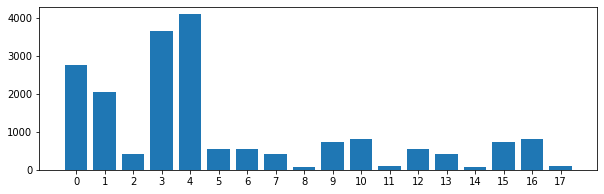

In [16]:
plt.figure(figsize=(10, 3))
plt.bar(range(18), full_labels['class'].value_counts().sort_index())
plt.xticks(np.arange(0, 18, step=1))
plt.show()

In [22]:
full_labels = pd.read_csv('/opt/ml/correct_label.csv')
full_labels.drop('Unnamed: 0', axis=1, inplace=True)
full_labels

file  gender  mask  age  \
0      /opt/ml/input/data/train/images/000001_female_...       1     0    1   
1      /opt/ml/input/data/train/images/000001_female_...       1     1    1   
2      /opt/ml/input/data/train/images/000001_female_...       1     0    1   
3      /opt/ml/input/data/train/images/000001_female_...       1     0    1   
4      /opt/ml/input/data/train/images/000001_female_...       1     2    1   
...                                                  ...     ...   ...  ...   
18895  /opt/ml/input/data/train/images/006959_male_As...       0     0    0   
18896  /opt/ml/input/data/train/images/006959_male_As...       0     0    0   
18897  /opt/ml/input/data/train/images/006959_male_As...       0     2    0   
18898  /opt/ml/input/data/train/images/006959_male_As...       0     0    0   
18899  /opt/ml/input/data/train/images/006959_male_As...       0     0    0   

           id  class  
0      000001      4  
1      000001     10  
2      000001      4  
3      000001      4  
4      000001     16  
...       ...    ...  
18895  006959      0  
18896  006959      0  
18897  006959     12  
18898  006959      0  
18899  006959      0  

[18900 rows x 6 columns]

이미지 랜덤으로 몇 개 확인해보기

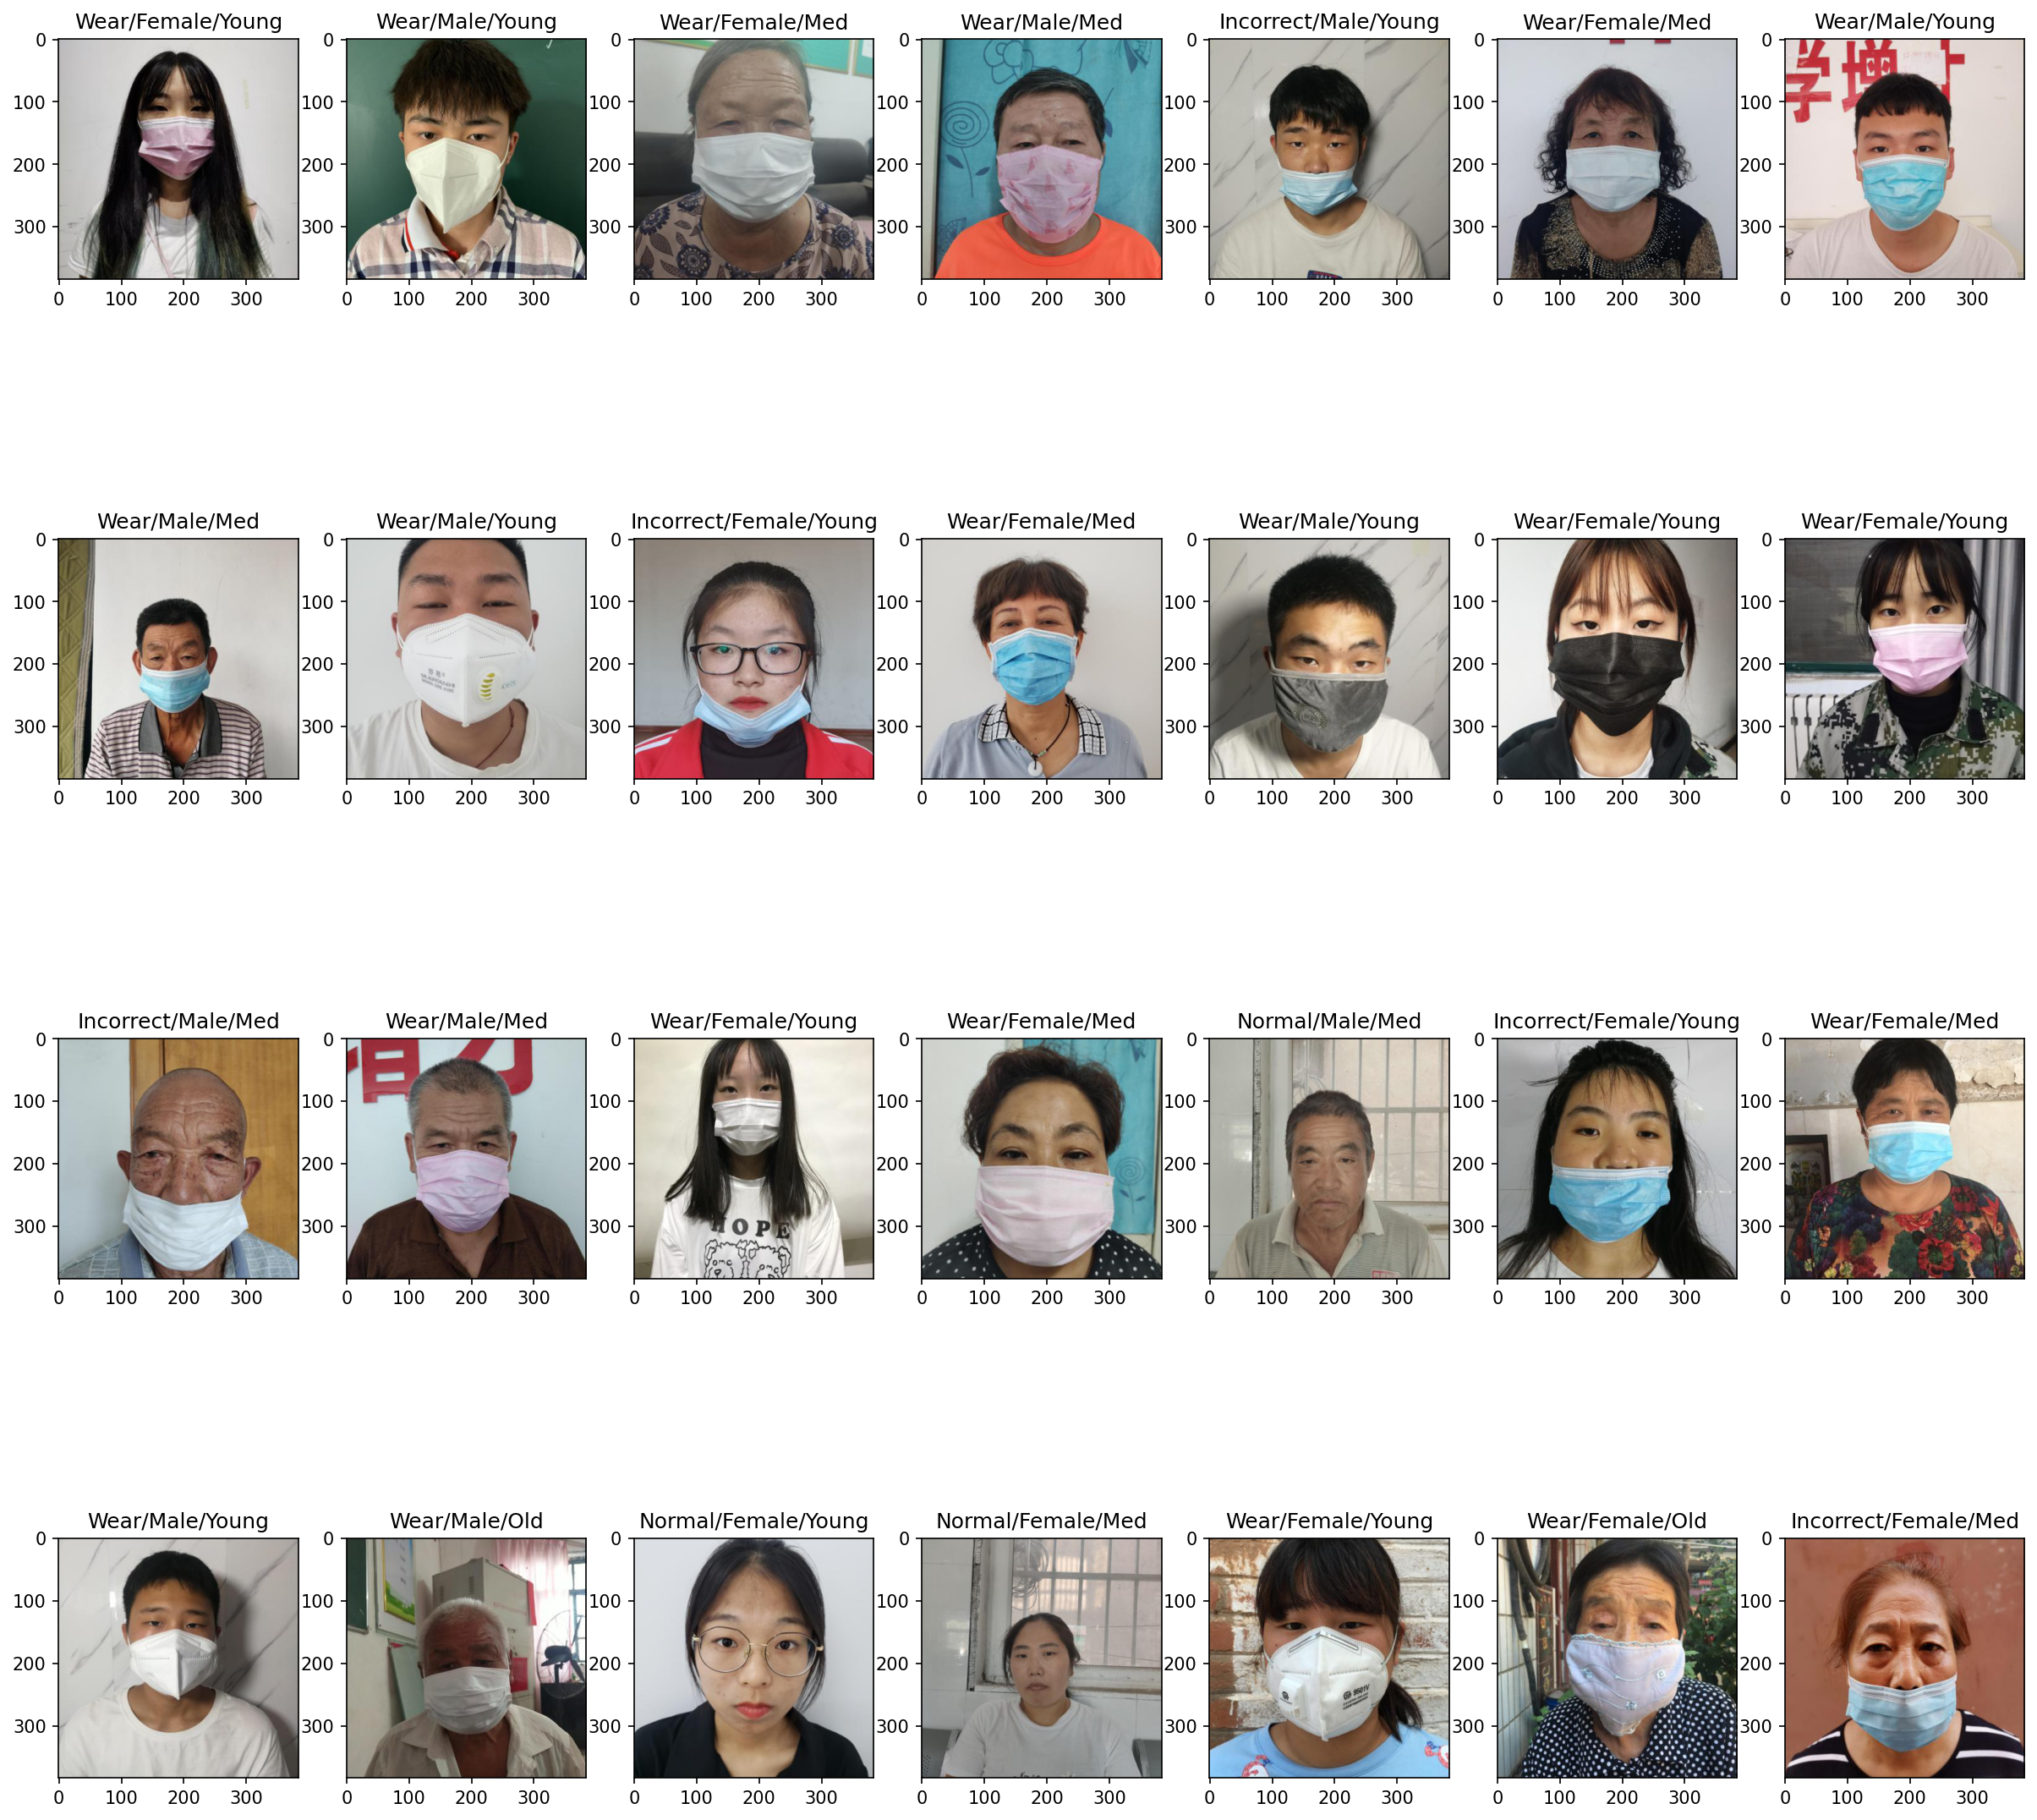

In [26]:
from random import randint

class_description = {0:'Wear/Male/Young', 1:'Wear/Male/Med', 2:'Wear/Male/Old',
                    3:'Wear/Female/Young', 4:'Wear/Female/Med', 5:'Wear/Female/Old',
                    6:'Incorrect/Male/Young', 7:'Incorrect/Male/Med', 8:'Incorrect/Male/Old',
                     9:'Incorrect/Female/Young', 10:'Incorrect/Female/Med', 11:'Incorrect/Female/Old',
                     12:'Normal/Male/Young', 13:'Normal/Male/Med', 14:'Normal/Male/Old',
                     15:'Normal/Female/Young', 16:'Normal/Female/Med', 17:'Normal/Female/Old'}

fig, axes = plt.subplots(4, 7, figsize=(20,20), dpi=150)
for i in range(4):
    for j in range(7):
        n = randint(0, 18900)
        im = Image.open(full_labels['file'][n])
        im = T.CenterCrop(384)(im)
        axes[i][j].imshow(im)
        axes[i][j].set_title(class_description[full_labels['class'][n]])
plt.show()

학습 데이터셋 클래스 생성

In [27]:
# Train/Validation Set 나누기
# from random import shuffle
from sklearn.model_selection import train_test_split

x, y = full_labels['file'], full_labels['mask']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=17, stratify=y)

In [28]:
len(x_train), len(x_valid), len(y_train), len(y_valid)

(17010, 1890, 17010, 1890)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


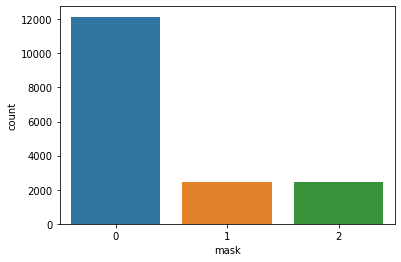

In [29]:
import seaborn as sns
sns.countplot(y_train)

In [38]:
from tqdm import tqdm

class TrainDataset(Dataset):
    def __init__(self, file_path, labels, transform, train=True):
        self.train = train
        self.transform = transform
        self.y = labels.tolist()
        self.X = []
        for x in tqdm(file_path):
            self.X.append(self.transform(Image.open(x)))
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.train == False:
            return X
        return X, torch.tensor(y)
        

class TestDataset(Dataset):
    def __init__(self, file_path, transform):
        self.transform = transform
        self.X_path = file_path
        self.X = []
        for x in tqdm(self.X_path):
            self.X.append(self.transform(Image.open(x)))
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

학습 데이터셋 object 생성
mean, std, resize -> pytorch pretrained model 공식 가이드 참조

In [39]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
CROP_SIZE = 384
RESIZE = 224

transform = T.Compose([
            T.CenterCrop(CROP_SIZE),
            T.Resize(RESIZE),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std)])

In [40]:
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
test_path = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

In [42]:
# MaskTrainDataset = TrainDataset(file_path = x_train,
#                                 labels = y_train,
#                                 transform = transform,
#                                train=True)

MaskValidDataset = TrainDataset(file_path = x_valid,
                                labels = y_valid,
                                transform = transform,
                               train=True)

MaskTestDataset = TestDataset(file_path = test_path,
                              transform = transform)

100%|██████████| 12600/12600 [01:59<00:00, 105.70it/s]


테스트 데이터셋 object 생성
데이터 로더에 학습/테스트 데이터셋 넣기

In [43]:
BATCH_SIZE = 128
NUM_WORKERS = 1

train_dataloader = DataLoader(MaskTrainDataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(MaskValidDataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(MaskTestDataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

pre-trained model의 classifier만 gradient update하게 하기 위한 함수 정의

In [44]:
import torchvision.models as models
from torchsummary import summary

In [45]:
from torchvision import models

class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Linear(512, 128, bias=True)
        self.final = nn.Linear(128, 3, bias=True)
        
    def forward(self, x):
        x = self.base(x)
        x = self.final(x)
        return x

In [46]:
mymodel = MaskModel().to(device)

loss function과 optimizer 정의

In [52]:
from torch.optim import Adam
import torch.optim as optim
LEARNING_RATE = 1e-5

criterion = nn.CrossEntropyLoss()

optM = Adam(mymodel.parameters(), lr=LEARNING_RATE)

# schM = optim.lr_scheduler.StepLR(optM, step_size=10, gamma=0.75)

evaluation function 정의

In [49]:
def train(model, optimizer, train_loader, val_loader, device, epochs=20):
    '''
    writer : tensorboard writer
    '''

    criterion = torch.nn.CrossEntropyLoss()

    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in tqdm(iter(train_loader)):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()        
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.squeeze())
            acc = class_acc(y_pred, y_batch.squeeze())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
        # validation set eval
        with torch.no_grad(): 
            val_loss = 0
            val_acc = 0
            for x_val, y_val in iter(val_loader):  
                x_val = x_val.to(device)  
                y_val = y_val.to(device)
#                 model.eval()  

                yhat = model(x_val)  
                val_loss += criterion(yhat, y_val.squeeze()).item()
                val_acc += class_acc(yhat, y_val.squeeze()).item()


        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.4f} | Acc: {epoch_acc/len(train_loader):.3f} \
        | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc/len(val_loader):.3f}')

In [50]:
def class_acc(y_pred, y_test):    
    output = torch.argmax(y_pred, dim=1)
    correct = sum(output == y_test)/len(output)
    return correct

Training!

In [53]:
train(
    model = mymodel,
    optimizer = optM,
    train_loader = train_dataloader,
    val_loader = valid_dataloader,
    device = device,
    epochs = 5
)

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 001: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0019 | Val Acc: 0.999


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 002: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0002 | Val Acc: 1.000


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 003: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0017 | Val Acc: 0.999


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 004: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0008 | Val Acc: 0.999


100%|██████████| 132/132 [00:44<00:00,  2.96it/s]


Epoch 005: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0025 | Val Acc: 0.998


제출할 submission 파일 초안 생성

In [54]:
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
submission

ImageID  ans
0      cbc5c6e168e63498590db46022617123f1fe1268.jpg    0
1      0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    0
2      b549040c49190cedc41327748aeb197c1670f14d.jpg    0
3      4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg    0
4      248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg    0
...                                             ...  ...
12595  d71d4570505d6af8f777690e63edfa8d85ea4476.jpg    0
12596  6cf1300e8e218716728d5820c0bab553306c2cfd.jpg    0
12597  8140edbba31c3a824e817e6d5fb95343199e2387.jpg    0
12598  030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg    0
12599  f1e0b9594ae9f72571f0a9dc67406ad41f2edab0.jpg    0

[12600 rows x 2 columns]

테스트 데이터 예측값 submission['ans']에 저장

In [55]:
def predictTestData(model, loader, transform, device):
#         model.eval()
        predict = []
        for images in tqdm(loader):
            with torch.no_grad():
                images = images.to(device)
                pred = model(images)
                pred = pred.argmax(dim=-1)
                predict.extend(pred.cpu().numpy())
#         self.data['ans'] = all_predictions
        return np.array(predict)

In [56]:
submission['mask'] = predictTestData(mymodel, test_dataloader, transform, device)

100%|██████████| 99/99 [00:14<00:00,  6.88it/s]


랜덤으로 test set 사진과 예측값 확인

테스트셋 예측값 18개 클래스 분포 확인

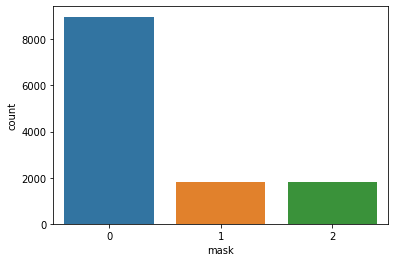

In [57]:
sns.countplot(x='mask', data=submission)

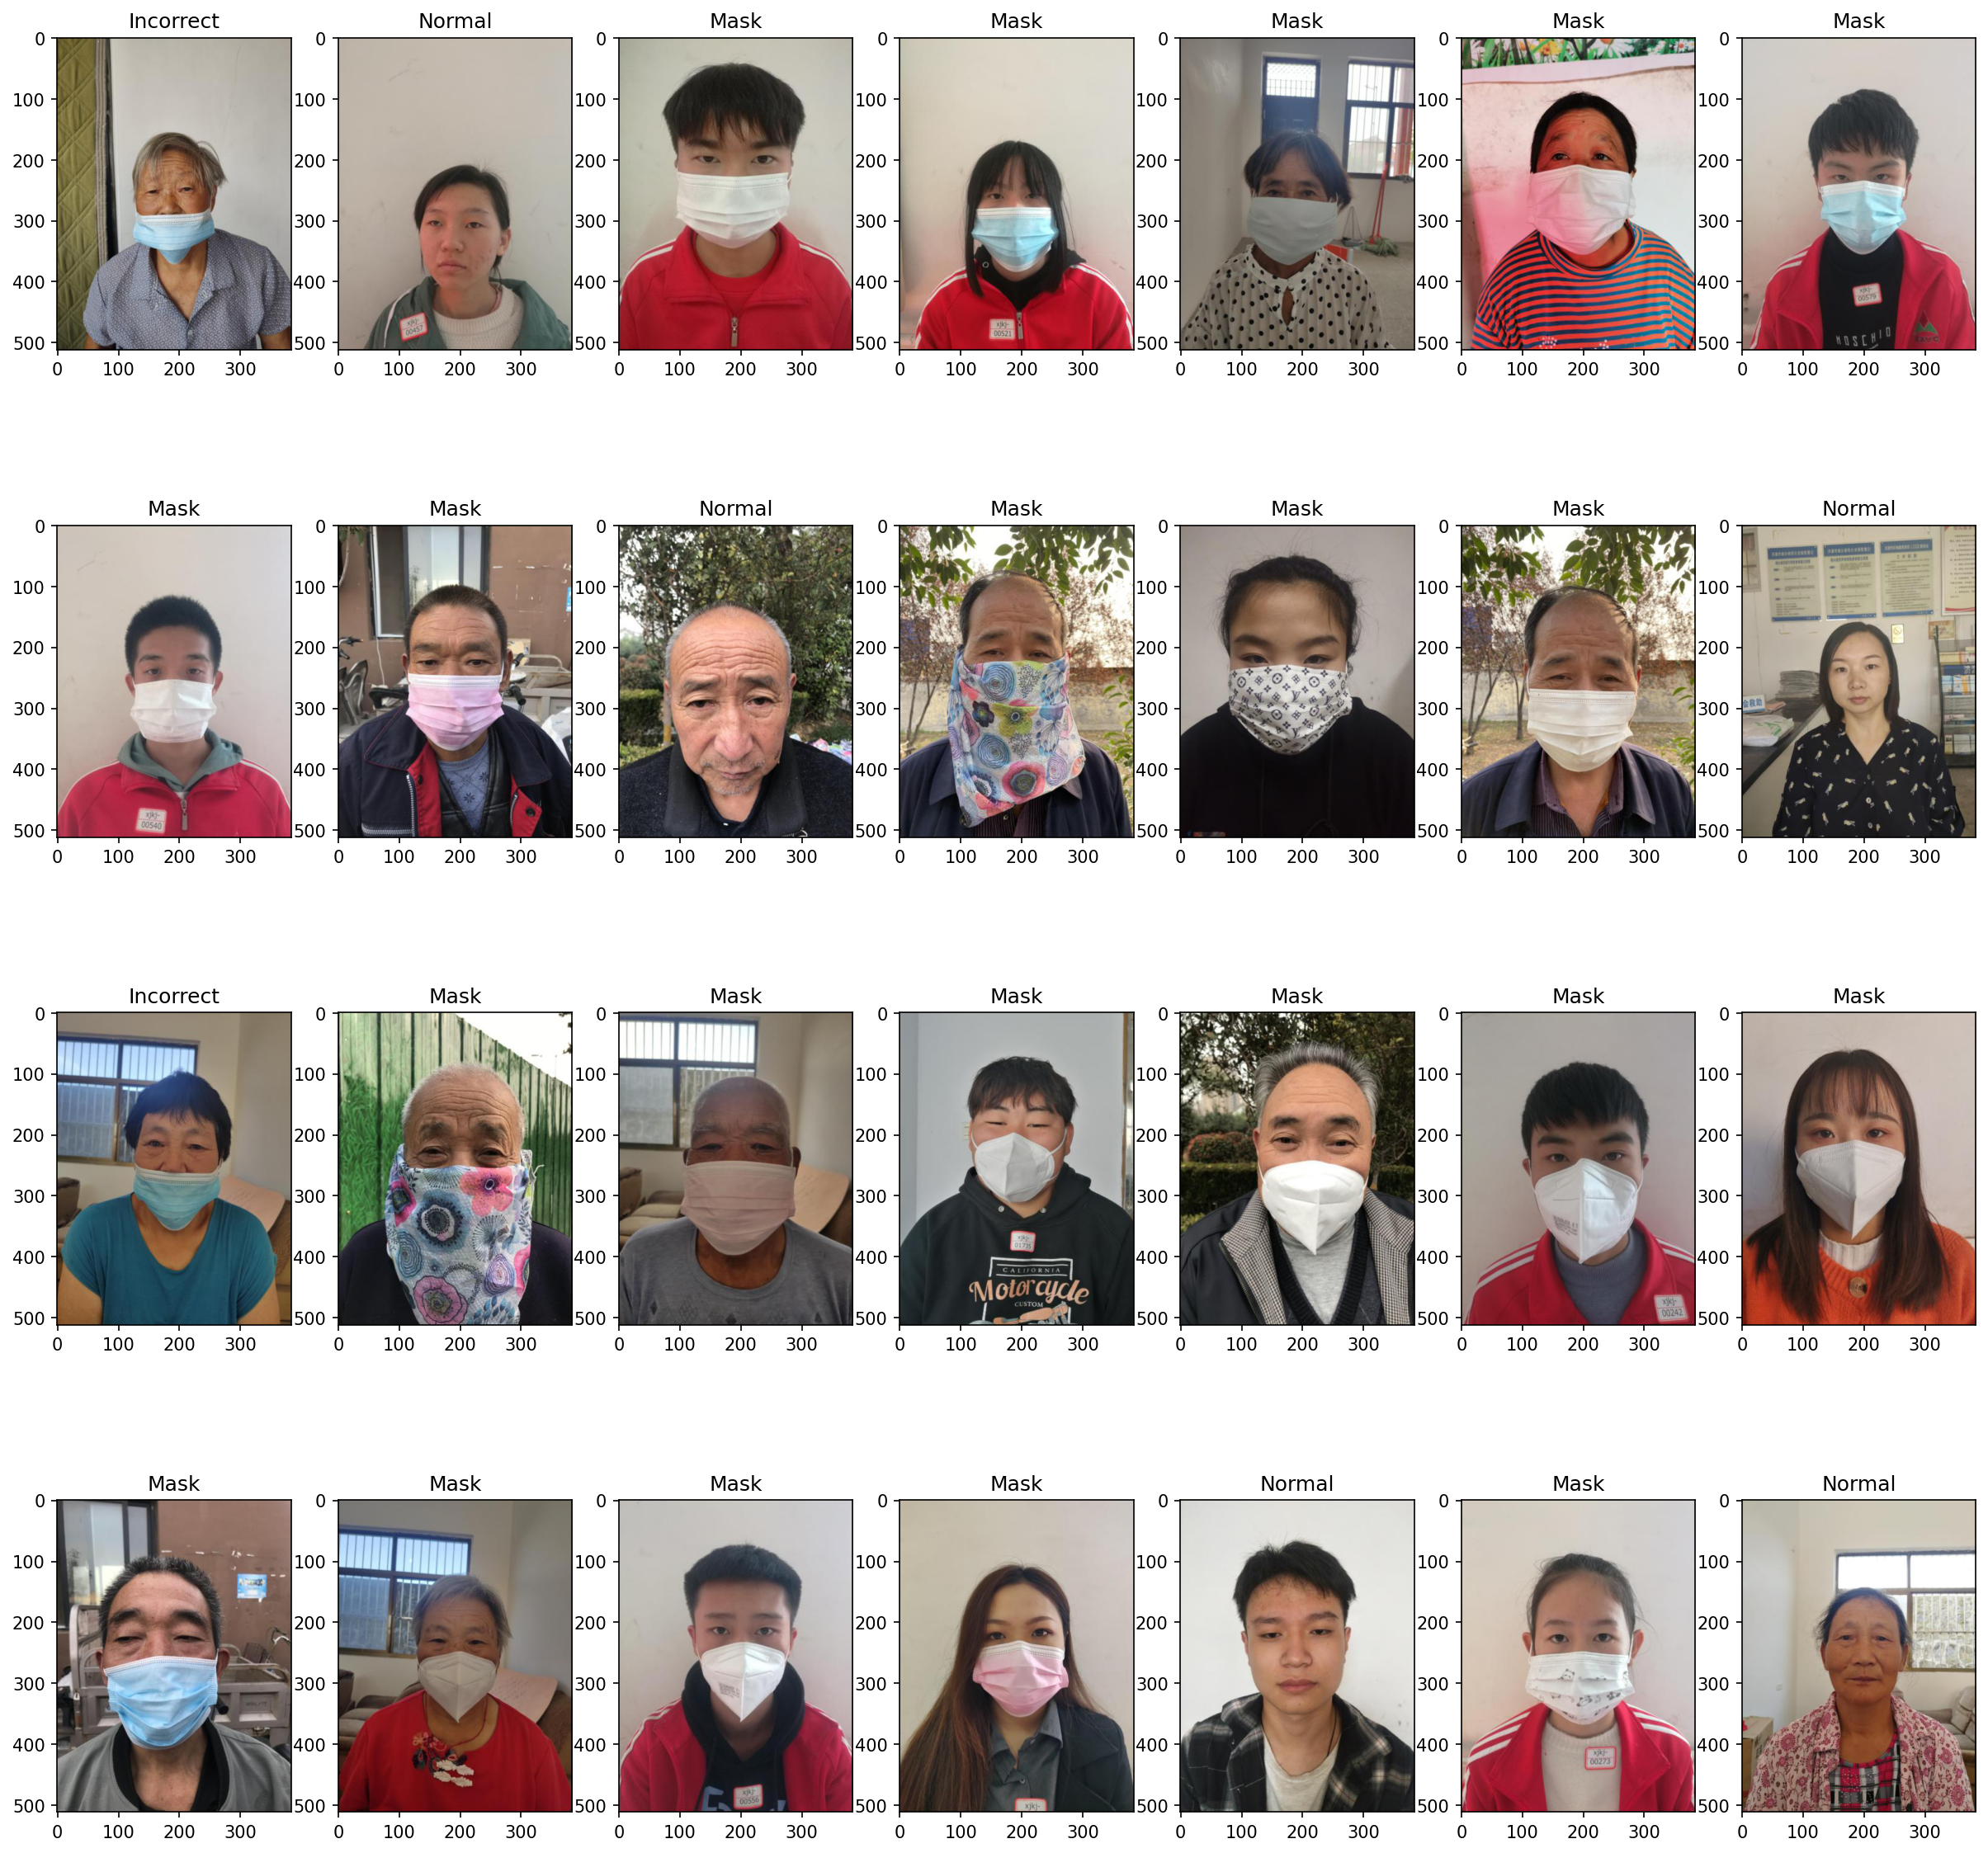

In [60]:
from random import randint
test_dir = '/opt/ml/input/data/eval/images/'

%matplotlib inline

mask = {0:'Mask', 1:'Incorrect', 2:'Normal'}

fig, axes = plt.subplots(4, 7, figsize=(20,20), dpi=150)
for i in range(4):
    for j in range(7):
        n = randint(0, 12599)
        im = Image.open(os.path.join(test_dir, submission.ImageID[n]))
#         im = transform(im)
        axes[i][j].imshow(im)
        axes[i][j].set_title(mask[submission['mask'][n]])
plt.show()

Done!

In [61]:
submission.to_csv('/opt/ml/mask.csv')

개선할 점
1. validation set 생성 및 관찰
2. EDA 더 신경써서
3. iaa 사용해서 data imbalance 개선
4. vgg가 아닌 resnet과 같은 더 좋은 모델 쓰기
5. scheduler도 적용해볼 것
6. tensorboard 사용